In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import random
import pickle
import seaborn as sns
import math
import sys

## 4.2 - The data
The following command downloads the dataset directly from the NCBI's GEO site. In case it doesn't work, the same Excel file is provided in this repository, under CaseStudies/RNAseq. 



In [1]:
import pandas as pd
data_df = pd.read_excel("RNASeqData.xlsx", engine="openpyxl")

In [2]:
data_df.head()

,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj,post_drug.vs.control_ShrunkenLog2FC,...,Raw_Orkambi_021_Base,Raw_Orkambi_021_V2,Raw_Orkambi_022_Base,Raw_Orkambi_022_V2,Raw_Orkambi_024_Base,Raw_Orkambi_024_V2,Raw_Orkambi_025_Base,Raw_Orkambi_025_V2,Raw_Orkambi_026_Base,Raw_Orkambi_026_V2
0,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882,0.082631,...,113,89,31,125,44,78,113,98,38,70
1,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309,0.155902,...,40,36,26,87,23,72,74,55,64,53
2,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776,-0.359549,...,16,23,40,104,370,199,81,30,228,33
3,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514,-0.118870,...,130,71,28,178,62,219,176,106,160,121
4,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817,0.075925,...,192,157,71,228,130,185,198,114,131,157


The column headers have some unnecessary information so we will remove them to make it cleaner. 

In [4]:
import re

data_df = data_df.rename(columns=lambda x: re.sub("w_[0-9]+_O", "w_O",x))
data_df = data_df.rename(columns=lambda x: re.sub("m_[0-9]+_O", "m_O",x))

In [5]:
columns = list(data_df.columns) 
columns[:5]

['RowID', 'ID', 'Description', 'EntrezID', 'Class']

### 4.3.1 normalization

The first 5 columns are gene descriptions and identifiers. In this exercise we will start with the **raw** data. First we obtain all the columns that contain the word **raw** and use them to perform our normalization.

As discussed in the book, there are many different methods of normalizing the data and we are choosing to use a very simply approach. For each gene g, this approach first maps the raw count of g to the relative abundance of g compared to all other genes for this patient; second, it multiplies that relative abundance by one million.

In [6]:
raw_cols = [x for x in columns if "Raw" in x] # get all raw values
raw_cols_sums = data_df[raw_cols].sum()
norm_cpm = [data_df[raw_cols].iloc[i]*1000000/raw_cols_sums \
            for i in range(data_df.shape[0])]

In [7]:
norm_cpm_df = pd.DataFrame(data=norm_cpm)
norm_cpm_df.shape

(15570, 60)

In [8]:
norm_cpm_df = pd.concat([norm_cpm_df, data_df[columns[:9]]], axis=1)
norm_cpm_df.head()


,Raw_10_HC_Auto_066_237,Raw_Orkambi_006_Base,Raw_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_Orkambi_007_Base,Raw_Orkambi_009_V2,Raw_16_HC_Auto_072_243,Raw_Orkambi_009_Base,Raw_Orkambi_010_V2,Raw_19_HC_Auto_074_245,...,Raw_Orkambi_026_V2,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj
0,3.573084,2.084737,4.012814,2.405698,2.554380,5.560526,3.970076,3.336330,2.125438,4.603163,...,3.045395,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882
1,2.161495,1.700706,3.009610,1.359742,1.516663,2.439823,2.540848,1.811150,1.121759,2.478626,...,2.305799,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309
2,3.264299,5.925042,2.221379,2.457996,1.636400,0.879471,3.334864,1.072392,1.859759,8.940759,...,1.435686,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776
3,7.102057,4.718089,7.058253,4.811396,4.629815,4.056914,7.717827,3.241006,4.457517,6.594917,...,5.264183,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514
4,8.778318,7.022272,7.094081,6.118841,6.465776,7.461318,6.923812,5.790915,5.933516,6.727700,...,6.830386,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817


In [9]:
norm_cpm_df.iloc[:,:5].sum()

Raw_10_HC_Auto_066_237    1000000.0
Raw_Orkambi_006_Base      1000000.0
Raw_Orkambi_007_V2        1000000.0
Raw_13_HC_Auto_068_239    1000000.0
Raw_Orkambi_007_Base      1000000.0
dtype: float64

### 4.3.2 Remove genes that contain zeroes

In [10]:

genes_with_min_greaterthan_zero = [ norm_cpm_df[raw_cols].iloc[i].values.min() > 0 for i in range(norm_cpm_df.shape[0])]


Keep only genes with no zeroes

In [11]:
data_df_subset = norm_cpm_df[genes_with_min_greaterthan_zero]
data_df_subset.shape

(15250, 69)

In [12]:
data_df_subset.head()

,Raw_10_HC_Auto_066_237,Raw_Orkambi_006_Base,Raw_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_Orkambi_007_Base,Raw_Orkambi_009_V2,Raw_16_HC_Auto_072_243,Raw_Orkambi_009_Base,Raw_Orkambi_010_V2,Raw_19_HC_Auto_074_245,...,Raw_Orkambi_026_V2,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj
0,3.573084,2.084737,4.012814,2.405698,2.554380,5.560526,3.970076,3.336330,2.125438,4.603163,...,3.045395,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882
1,2.161495,1.700706,3.009610,1.359742,1.516663,2.439823,2.540848,1.811150,1.121759,2.478626,...,2.305799,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309
2,3.264299,5.925042,2.221379,2.457996,1.636400,0.879471,3.334864,1.072392,1.859759,8.940759,...,1.435686,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776
3,7.102057,4.718089,7.058253,4.811396,4.629815,4.056914,7.717827,3.241006,4.457517,6.594917,...,5.264183,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514
4,8.778318,7.022272,7.094081,6.118841,6.465776,7.461318,6.923812,5.790915,5.933516,6.727700,...,6.830386,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817


In [13]:
number_of_zeroes_confirm = [ list(data_df_subset[raw_cols].values[i]).count(0) for i in range(data_df_subset.shape[0])]
[ print(str(y)+" "+str(number_of_zeroes_confirm[y])) for y in range(len(number_of_zeroes_confirm)) if number_of_zeroes_confirm[y] > 0]

[]

## 4.4 Distinguishing sick patients from healthy

In [14]:
healthy = [x for x in data_df_subset.columns if "HC" in x] # healthy control norm values
cf_base = [x for x in data_df_subset.columns if "Base" in x] # cystic fibrosis(cf) without treatment
cf_v2 = [x for x in data_df_subset.columns if "V2" in x] # cf with treatment


In [15]:
healthy

['Raw_10_HC_Auto_066_237',
 'Raw_13_HC_Auto_068_239',
 'Raw_16_HC_Auto_072_243',
 'Raw_19_HC_Auto_074_245',
 'Raw_21_HC_Immune_004',
 'Raw_23_HC_Auto_076_247',
 'Raw_26_HC_Auto_078_249',
 'Raw_29_HC_Auto_080_251',
 'Raw_3_HC_Auto_062_233',
 'Raw_42_HC_Auto_089_261',
 'Raw_4_HC_Immune_002',
 'Raw_7_HC_Auto_064_235',
 'Raw_HC_Auto_082_253',
 'Raw_HC_Auto_084_255',
 'Raw_HC_Auto_088_259',
 'Raw_HC_Auto_091_263',
 'Raw_HC_Auto_093_265',
 'Raw_HC_Auto_095_267',
 'Raw_HC_Immune_006',
 'Raw_HC_Immune_008']

The approach to determining genes that are differentially expressed is similar to the one we used for determining diets that are different by comparing the difference of the final weights. However, we are not looking for an increase in the mean difference. Rather we are looking for a change and we are not sure if the gene will increase or decrease due to either sickness or treatment.

For each gene g, we take the mRNA expression values of one group (e.g. healthy patients) and compare it with the expression values of gene g among another group (e.g. untreated cystic fibrosis patients).

To evaluate significance (i.e. calculate p-values), we check how often a shuffled set of values (shuffling  ignores whether a patient is in one group or another) shows a difference that is greater in absolute value than the observed difference. If that happens rarely, then the p-value is low.


In [16]:
def shuffle(grps):
	num_grps = len(grps)
	pool = []
	
	# pool all values
	for i in range(num_grps):
		pool.extend(grps[i])
	# mix them up
	random.shuffle(pool)
	# reassign to groups of same size as original groups
	new_grps = []
	start_index = 0
	end_index = 0
	for i in range(num_grps):
		end_index = start_index + len(grps[i])
		new_grps.append(pool[start_index:end_index])
		start_index = end_index
	return new_grps

In [17]:
def logFC(grpA, grpB):
    return math.log2( (sum(grpB) / float(len(grpB))) / (sum(grpA) / float(len(grpA))))

In [18]:
def lfc2meansig(grpA, grpB):

    # list of lists
    samples = [grpA, grpB]
    a = 0
    b = 1

    observed_mean_diff = logFC(samples[a], samples[b])
    #all_mean_diffs = []

    count = 0
    num_shuffles = 100000

    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = logFC(new_samples[a], new_samples[b])
        
        if abs(observed_mean_diff) <= abs(mean_diff):
            count = count + 1
    
    return count/num_shuffles

In [19]:
def avg_diff_sig_test(df_norm_hc, df_norm_cf):
    fullzip = list(zip(df_norm_hc.values, df_norm_cf.values))
    all_p_sig_values = [lfc2meansig(fullzip[i][0],fullzip[i][1]) for i in range(len(fullzip))]
    
    return list(all_p_sig_values)

In [25]:
data_df_subset.iloc[0:5]

,Raw_10_HC_Auto_066_237,Raw_Orkambi_006_Base,Raw_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_Orkambi_007_Base,Raw_Orkambi_009_V2,Raw_16_HC_Auto_072_243,Raw_Orkambi_009_Base,Raw_Orkambi_010_V2,Raw_19_HC_Auto_074_245,...,Raw_Orkambi_026_V2,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj
0,3.573084,2.084737,4.012814,2.405698,2.554380,5.560526,3.970076,3.336330,2.125438,4.603163,...,3.045395,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882
1,2.161495,1.700706,3.009610,1.359742,1.516663,2.439823,2.540848,1.811150,1.121759,2.478626,...,2.305799,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309
2,3.264299,5.925042,2.221379,2.457996,1.636400,0.879471,3.334864,1.072392,1.859759,8.940759,...,1.435686,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776
3,7.102057,4.718089,7.058253,4.811396,4.629815,4.056914,7.717827,3.241006,4.457517,6.594917,...,5.264183,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514
4,8.778318,7.022272,7.094081,6.118841,6.465776,7.461318,6.923812,5.790915,5.933516,6.727700,...,6.830386,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817


In [30]:
import math
import random
random.seed(123)

import time
a = time.time()
norm_p_values = avg_diff_sig_test(data_df_subset[healthy], data_df_subset[cf_base])
b = time.time()
print(b - a)

53618.89300298691


In [31]:
norm_p_values[0:5]
#[0.0719, 0.36228, 0.43115, 0.06547, 0.97294]

[0.0719, 0.36228, 0.43115, 0.06547, 0.97294]

In [33]:
import pickle

pickle.dump( norm_p_values, open( "norm_p_values_unpaired_raw.p", "wb" ) )

In [34]:
norm_p_values = pickle.load( open( "norm_p_values_unpaired_raw.p", "rb" ) )

In [35]:
norm_p_values[0:5]

[0.0719, 0.36228, 0.43115, 0.06547, 0.97294]

In [50]:
sig_genes = [i for i in range(len(norm_p_values)) if norm_p_values[i] < 0.05]
print("Total number of genes that pass p-value threshold of 0.05:" + str(len(sig_genes)))

Total number of genes that pass p-value threshold of 0.05:7364


In [37]:
sig_gene_names=data_df_subset.ID.iloc[sig_genes]

In [38]:
sig_gene_names[:10]

5        AAED1
6        AAGAB
9         AAMP
11        AARS
12       AARS2
13       AASDH
14    AASDHPPT
15        AASS
17        AATK
18      ABALON
Name: ID, dtype: object

### 4.4.1 **Bonferroni correction**

In this method, we divide the threshold by the number of genes. So, if we take a threshold of 20% (or 0.2), the p-values that would pass this threshold would be `0.2/num_of_genes`. If any gene g had a p-value less than or equal to 1 in 100,000, then that would satisfy the 0.2 Bonferonni threshold because 0.2/15250 <= 2/100000

In [67]:
bon_sig_genes = [True if norm_p_values[i] < 0.2/len(norm_p_values) else False for i in range(len(norm_p_values))]

In [68]:
# Number og genes that pass bonferroni correction
print("Number of genes that pass bonferroni correction threshold of 0.2: ", str(sum(bon_sig_genes)))

Number of genes that pass bonferroni correction threshold of 0.2:  531


In [69]:
bon_sig_genes_names=data_df_subset["ID"].iloc[bon_sig_genes]
bon_sig_genes_names

13            AASDH
94            ACADS
100           ACAT1
141           ACSL1
143           ACSL4
            ...    
15238        ZNF467
15321    ZNF582-AS1
15356        ZNF624
15444        ZNF766
15466         ZNF79
Name: ID, Length: 531, dtype: object

### 4.4.2 Benjamini–Hochberg procedure

 Put the individual p-values in order, from smallest to largest. The smallest p-value has a rank of i=1, then next smallest has i=2, etc. Compare each individual p-value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest p-value that has P<(i/m)Q is significant, and all of the p-values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value. For our purposes the ciritical value is 0.05 meaning we tolerate 5% false positive rate (in this case meaning genes that are declared to be differentially expressed but they are not).

In [70]:
import numpy as np

def benjamin_hochberg_corrected_p_values(p_values, fdr):
  num_genes = len(p_values)
  sorted_indices = np.argsort(p_values)
  sorted_p_values = sorted(p_values)
  benjamini_hochberg_critical_values = [((i+1)/num_genes)*fdr for i in range(num_genes)]
  for i, p_value in reversed(list(enumerate(sorted_p_values))):
    if p_value < benjamini_hochberg_critical_values[i]:
      break
  return i, sorted_indices

In [71]:
i, sorted_indices = benjamin_hochberg_corrected_p_values(norm_p_values, 0.05)
num_fdr_sig_genes = i+1
print("Number of significant genes after BH correction: ", num_fdr_sig_genes)

Number of significant genes after BH correction:  6082


In [72]:
fdr_sig_genes_names = []

fdr_sig_genes_names = [data_df_subset["ID"].iloc[sorted_indices[i]] for i in range(num_fdr_sig_genes)]
fdr_sig_genes_names[:10]

['IL17RA',
 'CA5B',
 'LINC00671',
 'LRP11',
 'CREB5',
 'CREBL2',
 'GTF3A',
 'UBE2R2',
 'AEN',
 'LINC00938']

In [73]:
print(data_df_subset.loc[data_df_subset['ID'].isin(fdr_sig_genes_names)][['RowID', 'ID', 'Description']])

       RowID     ID                                      Description
5          6  AAED1  AhpC/TSA antioxidant enzyme domain containing 1
6          7  AAGAB         alpha- and gamma-adaptin binding protein
9         10   AAMP          angio associated migratory cell protein
11        12   AARS                           alanyl-tRNA synthetase
12        13  AARS2          alanyl-tRNA synthetase 2, mitochondrial
...      ...    ...                                              ...
15560  15561   ZW10                         zw10 kinetochore protein
15562  15563  ZWINT             ZW10 interacting kinetochore protein
15563  15564   ZXDA              zinc finger, X-linked, duplicated A
15567  15568    ZYX                                            zyxin
15569  15570   ZZZ3                 zinc finger ZZ-type containing 3

[6082 rows x 3 columns]


## An alternative way to adjust with Benjamini Hochberg method.

In [74]:
import statsmodels.stats.multitest as ssm
norm_p_values_np = np.array(norm_p_values, float)

rej, fdr_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="fdr_i")[:2]

In [75]:
tmp_sorted_fdr_adjpval = sorted(fdr_adjpval)
tmp_sorted_fdr_adjpval[530:531]

[0.0002871939736346516]

In [76]:
sum(np.array(tmp_sorted_fdr_adjpval)<0.05)

6082

## Violin Plots

The data we loaded is in a **wide** format where the values for each gene is presented in a different row.
We will **melt** the data to create a **long** format where each value is in a separate row and every row is a specific combination of gene and sample. This format will prove useful in creating violin plots using the seaborn package.

In [77]:
norm_hc_cf_with_genename = ["ID"]
norm_hc_cf_with_genename.extend(healthy)
norm_hc_cf_with_genename_melt = data_df_subset[norm_hc_cf_with_genename].melt("ID")
norm_hc_cf_with_genename_melt.variable="HC"
#print(norm_hc_cf_with_genename_melt.shape)


norm_cf_with_genename = ["ID"]
norm_cf_with_genename.extend(cf_base)
norm_cf_with_genename_melt = data_df_subset[norm_cf_with_genename].melt("ID")
norm_cf_with_genename_melt.variable="CF"
#print(norm_cf_with_genename_melt.shape)

norm_hc_cf_with_genename_melt = norm_hc_cf_with_genename_melt.append(norm_cf_with_genename_melt, ignore_index=True)
norm_hc_cf_with_genename_melt.head()

,ID,variable,value
0,A1BG,HC,3.573084
1,A1BG-AS1,HC,2.161495
2,A2M-AS1,HC,3.264299
3,AAAS,HC,7.102057
4,AACS,HC,8.778318


In [85]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(bon_sig_genes_names[3:4])]


<AxesSubplot:xlabel='ID', ylabel='value'>

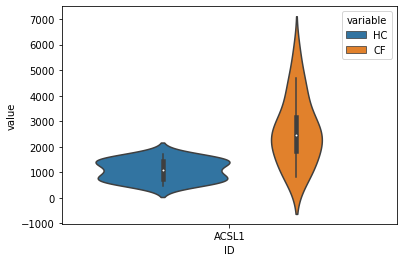

In [86]:
import seaborn as sns
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)

## 4.5 Healthy vs CF confidence interval

In [87]:
# We will use the genes that passed bonferroni correction cutoff.
data_df_subset_bon = data_df_subset[data_df_subset.ID.isin(bon_sig_genes_names)]
df_norm_hc_bon_sig = data_df_subset_bon[healthy]
df_norm_cf_bon_sig = data_df_subset_bon[cf_base]
print(df_norm_cf_bon_sig.shape,df_norm_hc_bon_sig.shape)

(531, 20) (531, 20)


In [88]:
def bootstrap(x):
	samp_x = []
	for i in range(len(x)):
		samp_x.append(random.choice(x))
	return samp_x

In [155]:
def diff2meanconf(grpA, grpB, num_resamples):
    # list of lists
    samples = [grpA, grpB] 
    a = 0
    b = 1

    #observed_mean_diff = logFC(samples[a], samples[b])
    out = []                # will store results of each time we resample
    for i in range(num_resamples):
        # get bootstrap samples for each of our groups
        # then compute our statistic of interest
        # append statistic to out
        bootstrap_samples = []  # list of lists
        for sample in samples:
            bootstrap_samples.append(bootstrap(sample))
        # now we have a list of bootstrap samples, run meandiff
        out.append(logFC(bootstrap_samples[a], bootstrap_samples[b]))
    out.sort()
    
    return(out)

In [156]:
def diff2meanJustconf(out, conf_interval):
    tails = (1 - conf_interval) / 2
    num_resamples = 1000
    #out = diff2meanconf(grpA, grpB, num_resamples)
    # in case our lower and upper bounds are not integers,
    # we decrease the range (the values we include in our interval),
    # so that we can keep the same level of confidence
    lower_bound = int(math.ceil(num_resamples * tails))
    upper_bound = int(math.floor(num_resamples * (1 - tails)))
    return([out[lower_bound], out[upper_bound]])

In [157]:
random.seed(123)
fullzip = list(zip(df_norm_hc_bon_sig.values, df_norm_cf_bon_sig.values))
all_meandiff = [diff2meanconf(fullzip[i][0],fullzip[i][1], 1000) for i in range(len(fullzip))]
   

In [159]:
pickle.dump( all_meandiff, open( "all_meandiff.p", "wb" ) )

In [160]:
all_meandiff = pickle.load( open( "all_meandiff.p", "rb" ) )

In [161]:
low_high = [diff2meanJustconf(all_meandiff[i], 0.90) for i in range(len(all_meandiff))] # 5% and 95% difference based on bootstrappng, for each gene.


In [162]:
low_high[:5]

[[-0.45809252378780735, -0.2294551892129989],
 [-1.0431639726328905, -0.4296991298389552],
 [-0.5499280254603696, -0.2949928896174936],
 [0.9148373928340311, 1.5671198546194254],
 [0.3680847334831579, 0.700322411187109]]

In [163]:
max_conf = [abs(max(low_high[i], key=abs)) for i in range(len(low_high))]

In [164]:
max_conf[:5]

[0.45809252378780735,
 1.0431639726328905,
 0.5499280254603696,
 1.5671198546194254,
 0.700322411187109]

In [165]:
sorted_max_conf = sorted(max_conf, reverse=True)
sorted_max_conf[:10]

[3.262913635899885,
 2.626661022642537,
 2.502153224130058,
 2.219187344453805,
 2.2108327516890443,
 2.1705966857324173,
 2.105639303185195,
 2.1053634337978915,
 2.0338462390198773,
 1.9625657208471563]

0


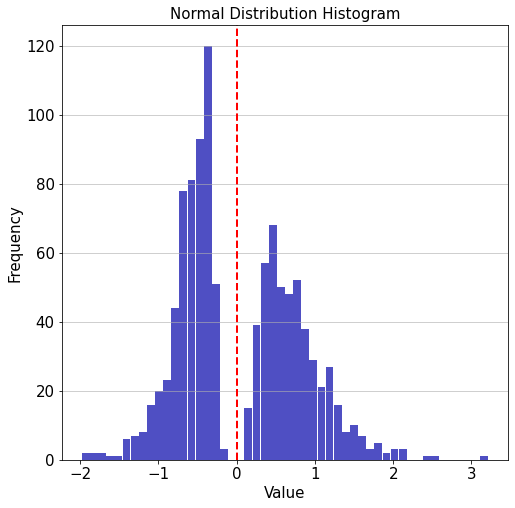

In [105]:
import matplotlib.pyplot as plt

def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =50)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.1, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()
    
draw_hist(low_high, 0)

0


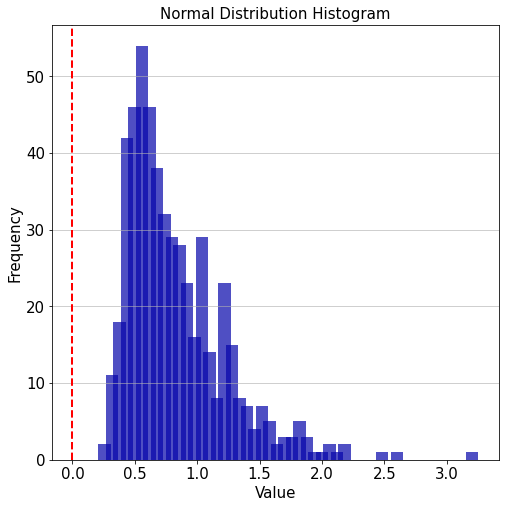

In [106]:
draw_hist(max_conf, 0)

In [107]:
sorted_max_conf_index = np.argsort(max_conf)
top10_conf_index = sorted_max_conf_index[::-1][:10]
top10_conf_index

array([245, 279, 296, 445,  17, 168, 202, 343, 332, 416], dtype=int64)

In [108]:
list(top10_conf_index)

[245, 279, 296, 445, 17, 168, 202, 343, 332, 416]

In [109]:
top10_conf_gene_names = data_df_subset_bon.ID.iloc[top10_conf_index]
top10_conf_gene_names

6886     LOC105372578
8139           MCEMP1
8458             MMP9
12605           SOCS3
555             ANXA3
4206             G0S2
5313            IL1R2
9800           PFKFB3
9470              OSM
11818          SEMA6B
Name: ID, dtype: object

In [110]:
top10_ci_genes = [data_df_subset_bon["ID"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]

In [111]:
top10_ci_genes

['LOC105372578',
 'MCEMP1',
 'MMP9',
 'SOCS3',
 'ANXA3',
 'G0S2',
 'IL1R2',
 'PFKFB3',
 'OSM',
 'SEMA6B']

In [112]:
top10_ci_gene_description = [data_df_subset_bon["Description"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]
top10_ci_gene_description

[nan,
 'mast cell-expressed membrane protein 1',
 'matrix metallopeptidase 9',
 'suppressor of cytokine signaling 3',
 'annexin A3',
 'G0/G1 switch 2',
 'interleukin 1 receptor type 2',
 '6-phosphofructo-2-kinase/fructose-2,6-biphosphatase 3',
 'oncostatin M',
 'semaphorin 6B']

In [113]:
top10conf = [low_high[i] for i in top10_conf_index]

In [114]:
top10conf

[[1.7142157972612742, 3.262913635899885],
 [1.5613732343563917, 2.626661022642537],
 [1.6080425782087475, 2.502153224130058],
 [1.378817614358683, 2.219187344453805],
 [1.2864098263437431, 2.2108327516890443],
 [1.3600582506137595, 2.1705966857324173],
 [0.9178112842707672, 2.105639303185195],
 [1.3968626872339254, 2.1053634337978915],
 [1.2716390044189732, 2.0338462390198773],
 [1.198988395967152, 1.9625657208471563]]

In [115]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[9:10])]
genestoplot.head()

,ID,variable,value
11555,SEMA6B,HC,1.235140
26805,SEMA6B,HC,0.993658
42055,SEMA6B,HC,1.016339
57305,SEMA6B,HC,1.018007
72555,SEMA6B,HC,1.068889


<AxesSubplot:xlabel='ID', ylabel='value'>

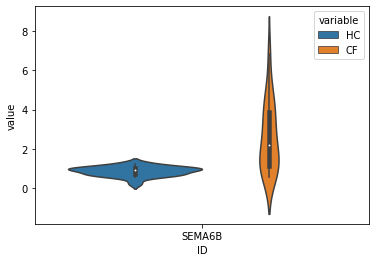

In [116]:
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

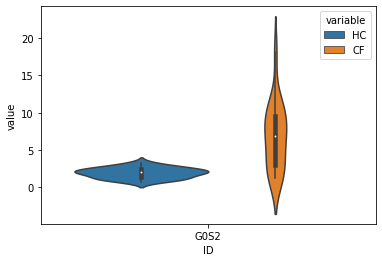

In [117]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[5:6])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

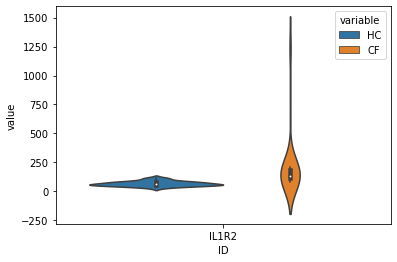

In [118]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[6:7])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


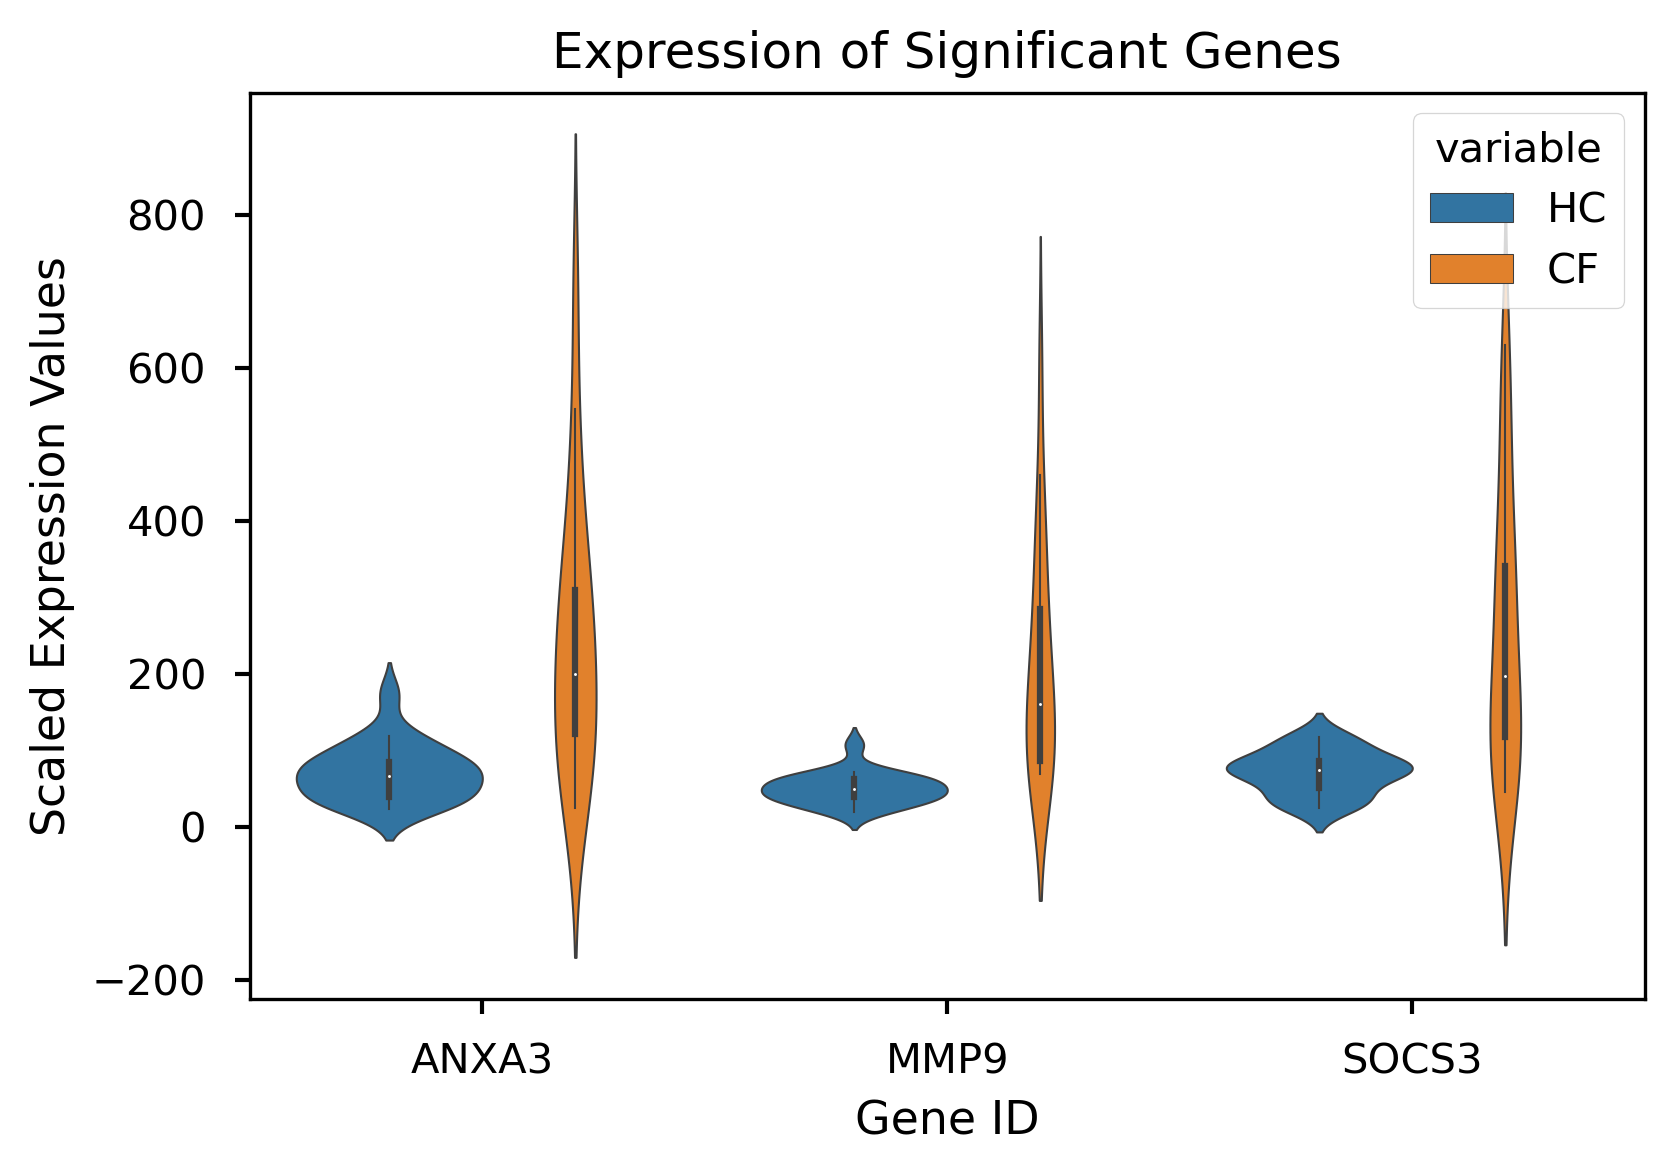

In [119]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(["MMP9","SOCS3","ANXA3"])]
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)
plt.title("Expression of Significant Genes")
plt.xlabel("Gene ID")
plt.ylabel("Scaled Expression Values")
plt.savefig('sig_genes_violin.png')

## Figure 4.1 - Confidence interval of genes identified in published work.

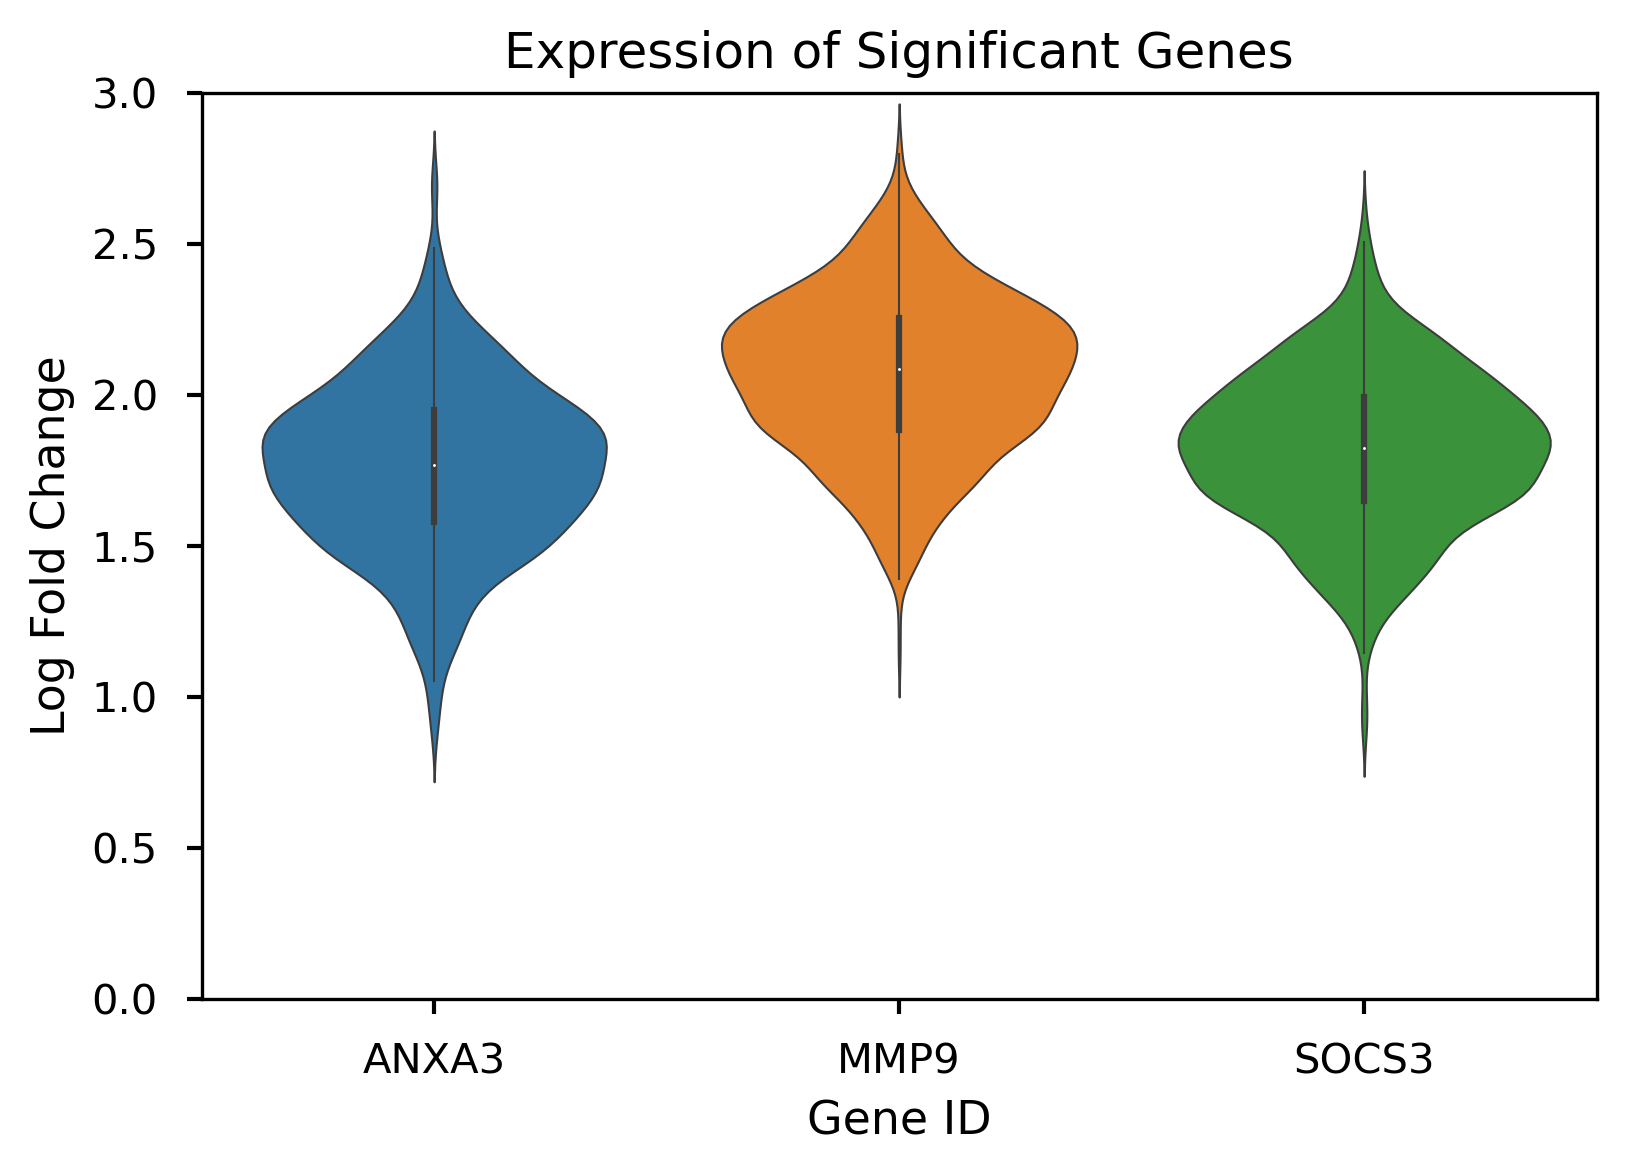

In [206]:
#all_meandiff_melt = {'features':X_train.columns,
#                 'mean':result.importances_mean,
#                 'sd':result.importances_std}
#feature_imp_df = pd.DataFrame(data=feature_imp_data)

all_meandiff_df = pd.DataFrame(data=all_meandiff)
all_meandiff_df["ID"] = bon_sig_genes_names.values
all_meandiff_melt = all_meandiff_df.melt("ID")
genestoplot=all_meandiff_melt[all_meandiff_melt.ID.isin(["MMP9","SOCS3","ANXA3"])]

plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="ID", y="value", data=genestoplot)
plt.title("Expression of Significant Genes")
plt.xlabel("Gene ID")
plt.ylabel("Log Fold Change")
plt.ylim(0, 3)
plt.savefig('sig_genes_violin.png')
#genestoplot

## 4.6.1 Random Forest Inference

First we need to make subset of the original dataframe to contain only our top 10 genes. We will than separate them into the healthy and cf dataframes so we can transpose them and add the corresponding labels. We transpose the data because we will be using the gene expression values as the variables to predict which sample/patient is healthy or has cystic fibrosis. 

In [120]:
data_df_subset_bon_top10ci = data_df_subset[data_df_subset.ID.isin(top10_ci_genes)]
df_norm_hc_bon_sig_top10ci = data_df_subset_bon_top10ci[healthy]
df_norm_cf_bon_sig_top10ci = data_df_subset_bon_top10ci[cf_base]
print(df_norm_hc_bon_sig_top10ci.shape,df_norm_cf_bon_sig_top10ci.shape)

(10, 20) (10, 20)


In [124]:
df_norm_healthy_T = df_norm_hc_bon_sig_top10ci.T
df_norm_base_T = df_norm_cf_bon_sig_top10ci.T
X1 = df_norm_healthy_T.values
X2 = df_norm_base_T.values
X = np.concatenate((X1, X2), axis=0)
X.shape

(40, 10)

In [125]:
Y1 = np.zeros((1,20))
Y2 = np.ones((1,20))
Y = np.concatenate((Y1, Y2), axis=1)
Y = np.reshape(Y, 40)
Y.shape

(40,)

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [145]:
test_precision = []
test_recall = []
test_f1 = []
for i in range(100):
    clf = RandomForestClassifier(random_state=i)
    scoring = {'precision': 'precision',
               'recall': 'recall',
              'f1_macro':'f1_macro'}
    scores = cross_validate(clf, X, Y, cv=5, scoring=scoring, return_train_score=True)
    test_precision.append(scores['test_precision'].mean())
    test_recall.append(scores['test_recall'].mean())
    test_f1.append(scores['test_f1_macro'].mean())

In [146]:
sum(test_recall)/len(test_recall)
#0.8524999999999991

0.8524999999999991

In [147]:
sum(test_precision)/len(test_precision)
#0.9134000000000007

0.9134000000000007

In [148]:
sum(test_f1)/len(test_f1)
#0.8678761904761916

0.8678761904761916

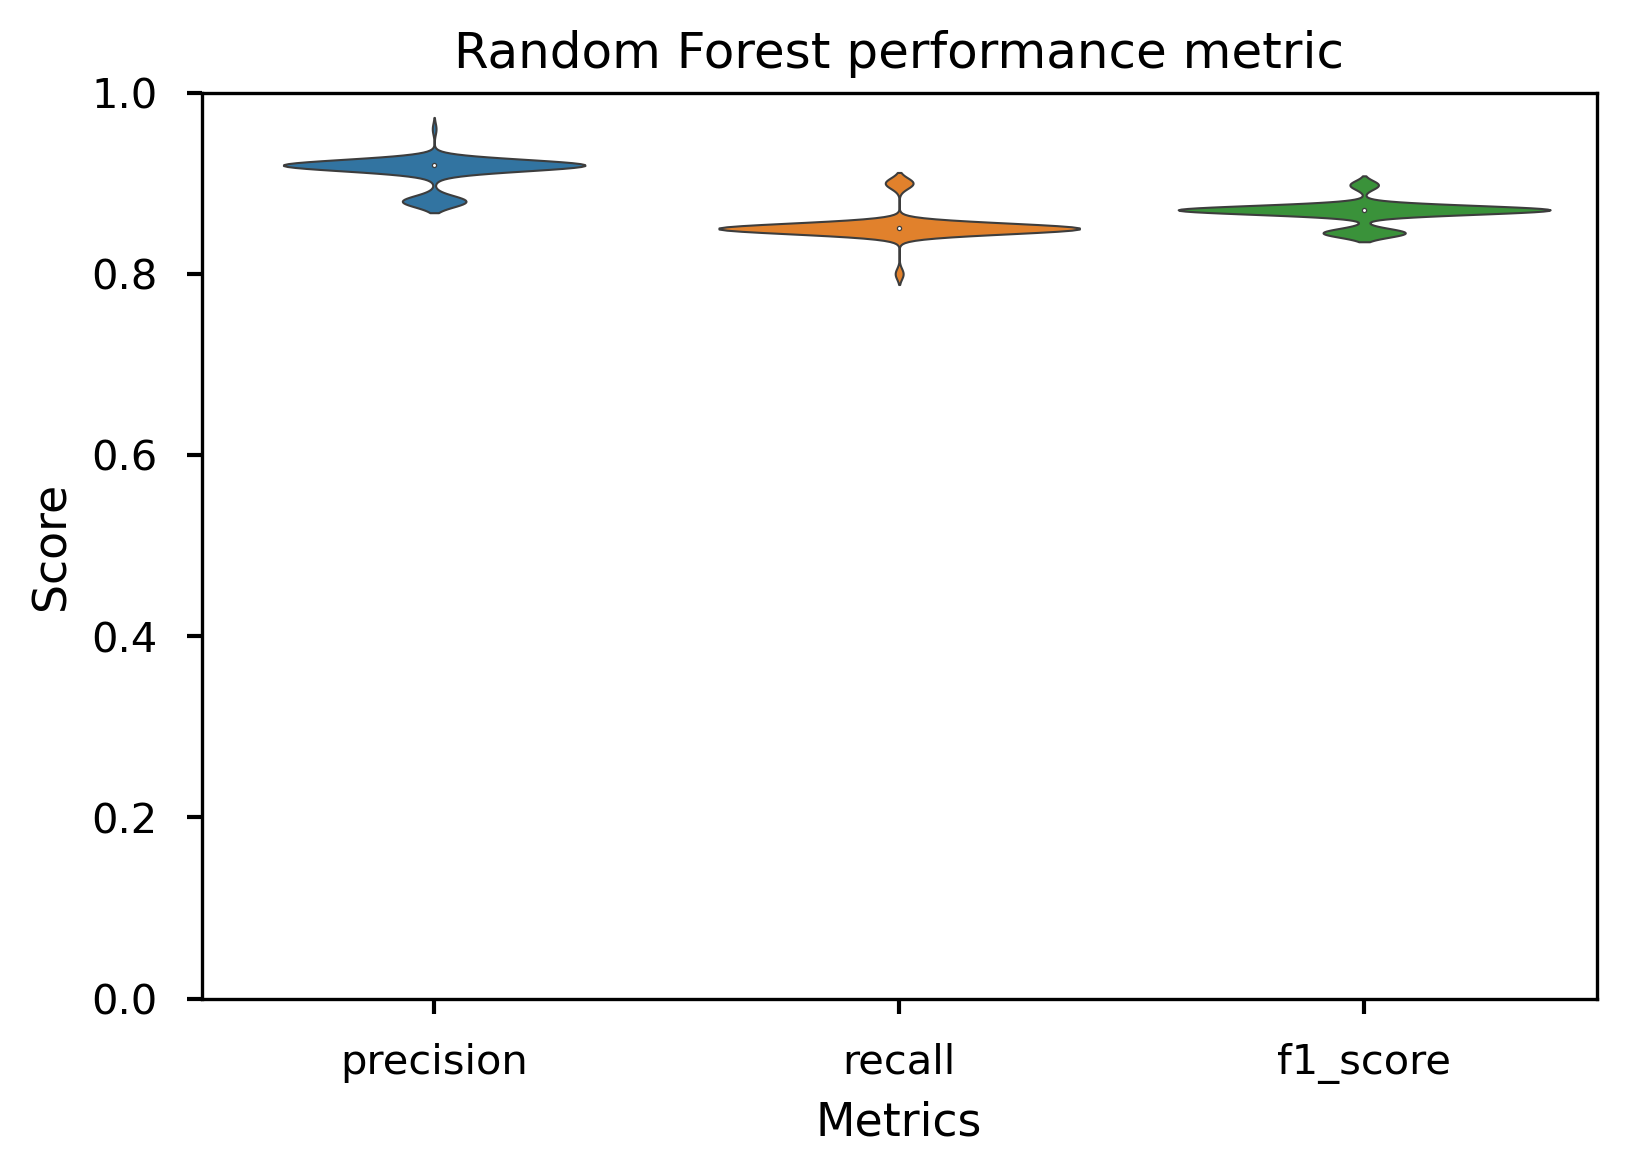

In [149]:
test_stats = {"f1_score" : test_f1,
              "precision": test_precision,
              "recall": test_recall}
test_stats_df = pd.DataFrame(data=test_stats)
test_stats_melt = pd.melt(test_stats_df, value_vars=["precision","recall","f1_score"])
#clf_feature_imp_df
#sns.scatterplot(y="precision", x="recall", data=test_stats_df, estimator=None)
test_stats_melt.iloc[98:105]
# make the axis start from 0.
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="variable",y="value",data=test_stats_melt)
plt.title("Random Forest performance metric")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.savefig('random_forest_rna_seq_performance.png')

## Figure 4.3 Violin plot of Feature importance

In [153]:
important_score = []
important_genes = []
for i in range(100):
    clf = RandomForestClassifier(random_state=i).fit(X, Y)
    important_score.extend(list(clf.feature_importances_))
    important_genes.extend(data_df_subset_bon_top10ci.ID.values)

clf_feature_imp = {"important" : important_score,
                   "genes" : important_genes}


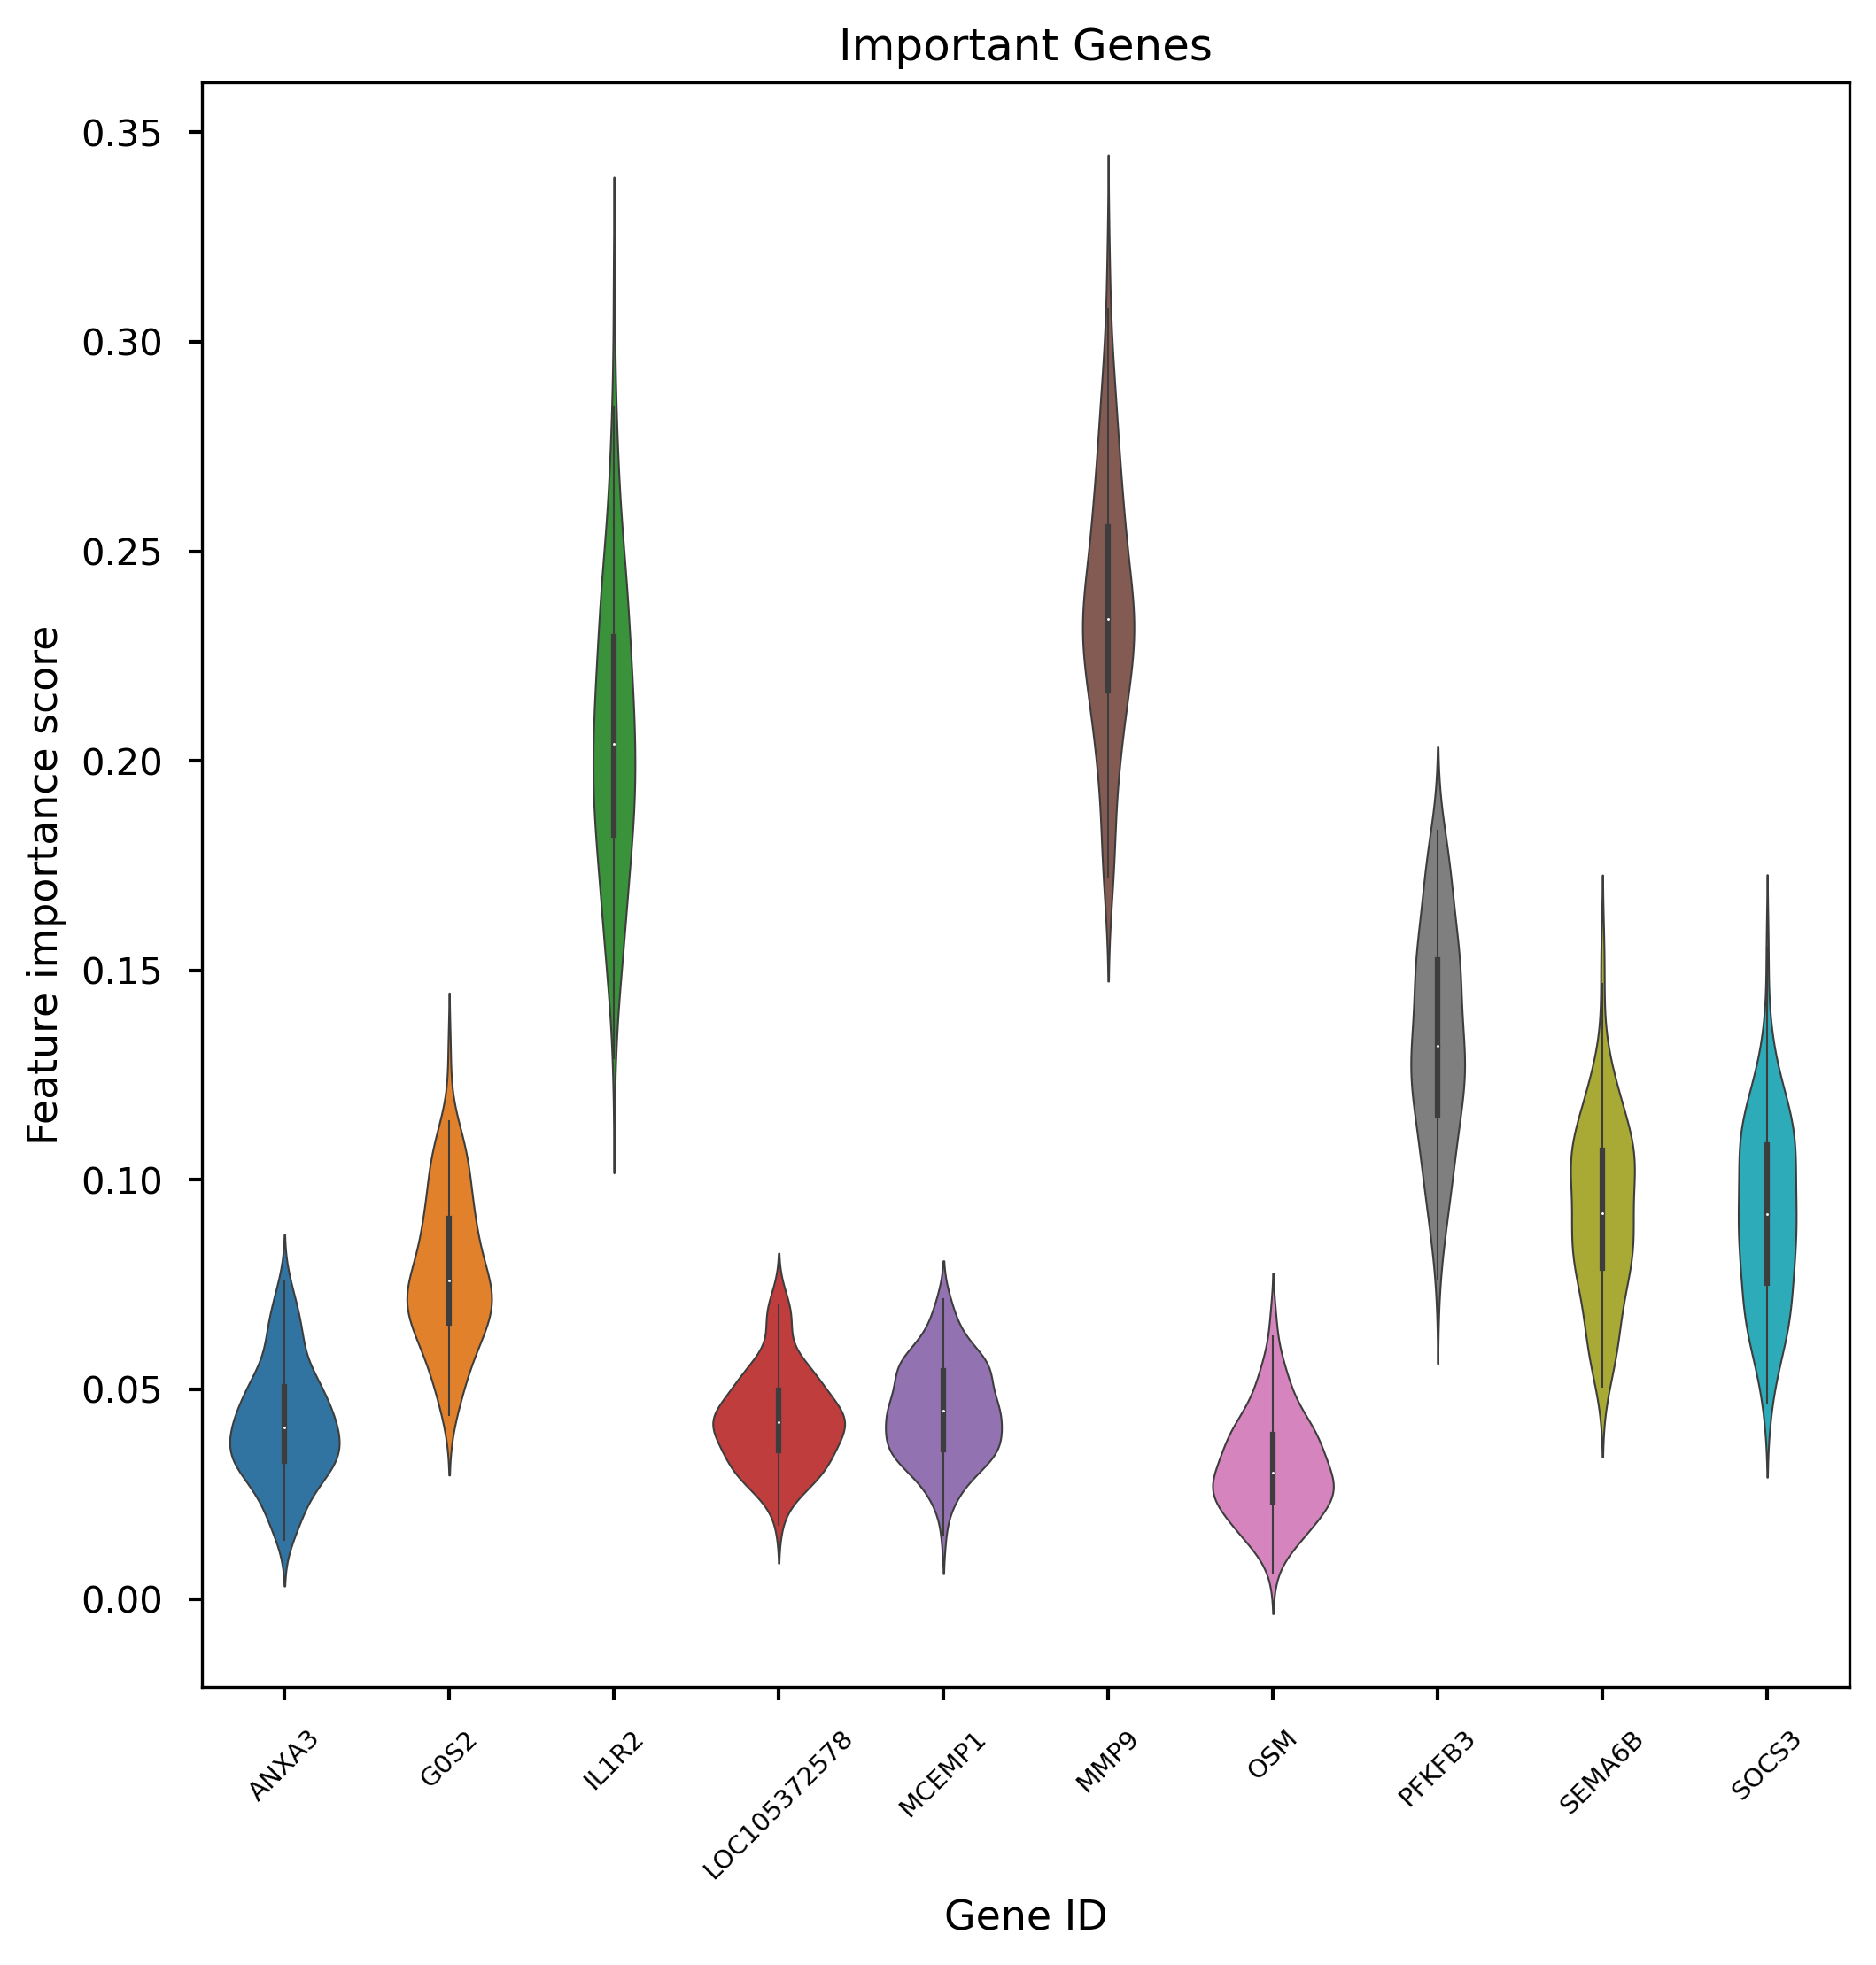

In [154]:
clf_feature_imp_df = pd.DataFrame(data=clf_feature_imp)
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(y="important",x="genes", data=clf_feature_imp_df)
plt.xticks(rotation=45, fontsize=7)
plt.title("Important Genes")
plt.xlabel("Gene ID")
plt.ylabel("Feature importance score")
plt.savefig('random_forest_important_genes.png')